In [1]:
import math
from random import seed
import os
import pandas as pd
from itertools import combinations
import scipy.cluster.hierarchy as sch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hypergeom
from sklearn.preprocessing import StandardScaler
from collections import Counter
from scipy.cluster import hierarchy
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import xlsxwriter

In [2]:
#Read all SNP files from FUMA analysis

# Directory path
directory_path = 'FUMA_dowloads_all_tissue/SNPs'

snp_df_list = []
disorder_names = []

# Iterate through files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.txt'):  # Process only .txt files
        # Extract disorder name from the filename
        disorder_name = filename.split('_')[1].split('.')[0]
        disorder_names.append(disorder_name)

        # Read the file as a DataFrame
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path, sep='\t')

        # Choose columns of interest
        df['disorder'] = disorder_name
        df = df[['uniqID','rsID','gwasP','disorder']]
        df = df.dropna()
        df.reset_index(inplace=True, drop=True)
        # Append the DataFrame to the list
        snp_df_list.append(df)

In [3]:
#Read all eQTL files from FUMA analysis

# Directory path
directory_path = 'FUMA_dowloads_all_tissue/eQTL'


gene_df_list = []
disorder_names = []

# Iterate through files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.txt'):  # Process only .txt files
        # Extract disorder name from the filename
        disorder_name = filename.split('_')[1].split('.')[0]
        disorder_names.append(disorder_name)

        # Read the file as a DataFrame
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path, sep='\t', low_memory=False)

        # Choose columns of interest
        df['disorder'] = disorder_name
        df = df[['uniqID','symbol','tissue','disorder']]
        df = df.dropna()
        df.reset_index(inplace=True, drop=True)
        # Append the DataFrame to the list
        gene_df_list.append(df)

In [4]:
# extract all genes from each disorder and save to file
output_folder = 'genes_to_EnrichR'
os.makedirs(output_folder, exist_ok=True)

# Iterate through each dataframe
for df in gene_df_list:
    # Extract disorder name
    disorder_name = df['disorder'].iloc[0] 
    
    # Extract unique symbols and save to txt file
    unique_symbols = df['symbol'].drop_duplicates().tolist()
    output_file = os.path.join(output_folder, f"{disorder_name}.txt")
    with open(output_file, 'w') as f:
        for symbol in unique_symbols:
            f.write(f"{symbol}\n")

In [5]:
#merge SNP and gene dataframes to map SNPs to genes
merged_list = []
for i in range(len(snp_df_list)):
    merged_df = pd.merge(snp_df_list[i], gene_df_list[i], on=['uniqID'], how='inner')
    #print(merged_df.head())
    merged_df.drop(columns=['disorder_x'], inplace=True)
    merged_df = merged_df[['uniqID','rsID','symbol','tissue','disorder_y']]
    merged_df = merged_df.rename(columns={'symbol':'gene','disorder_y': 'disorder'})
    merged_df.drop_duplicates(inplace=True)
    merged_list.append(merged_df)
all_merged = pd.concat(merged_list)

In [7]:
#Function to make binary matrix of SNPs and disorders
def make_binary_snp_matrix(df_list):
    concatenated= pd.concat(df_list)
    snp_df = concatenated[['rsID', 'disorder']]
    
    return snp_df.pivot_table(index='rsID', columns='disorder', aggfunc=lambda x: 1, fill_value=0)
    

In [8]:
#Function to make binary matrix of genes and disorders
def make_binary_gene_matrix(df_list):
    concatenated= pd.concat(df_list)
    gene_df = concatenated[['symbol', 'disorder']]
    
    return gene_df.pivot_table(index='symbol', columns='disorder', aggfunc=lambda x: 1, fill_value=0)

In [9]:
#Make a binary matrix of all snps to find out how many there are in each disorder
all_snps_binary = make_binary_snp_matrix(snp_df_list)
all_genes_binary = make_binary_gene_matrix(gene_df_list)
#snps_psych_binary = make_binary_SNPs_matrix(new_df_list)
# snps_other_binary = make_binary_SNPs_matrix(dfs_other)
# print('The number of SNPs shared between at least 2 disorders: ', (snps_psych_binary.sum(axis=1) >= 2).sum())



In [10]:
print(all_snps_binary.sum(axis=0))


disorder
ADHD           7018
ANOREXIA       2562
ANXIETY          84
ASD            4006
AUD            5984
BIL            9791
BPD           27077
CUD             719
EPILEPSY        462
FATIGUE         193
GOUT            269
HOARDING         79
IBS             432
LUPUS         17546
MDD           15332
MIGRAINE       2583
MS             1302
MYASTHENIA      713
OCD             130
PARKINSONS     5508
PTSD            186
RH            13819
SJOGRENS        621
SZC           41691
TOURETTES       292
dtype: int64


In [11]:
print(all_genes_binary.sum(axis=0))
#all_genes_binary.to_csv('all_genes_binary.csv')

disorder
ADHD          1135
ANOREXIA       474
ANXIETY         43
ASD            308
AUD            678
BIL           2434
BPD           2440
CUD            308
EPILEPSY        28
FATIGUE         73
GOUT           325
HOARDING        42
IBS             23
LUPUS         1888
MDD           1485
MIGRAINE       566
MS            1579
MYASTHENIA     502
OCD             44
PARKINSONS     802
PTSD           128
RH            2660
SJOGRENS        71
SZC           4149
TOURETTES      164
dtype: int64


In [12]:
all_snps_binary.to_csv('all_snps_binary.txt', sep='\t')
all_genes_binary.to_csv('all_genes_binary.txt', sep='\t')

In [11]:
def count_combos(binary_df, num_iterations):
# Set a seed for reproducibility
    np.random.seed(42)

    #num_iterations = 10

    # Get all possible combinations of disorders
    all_combinations = []
    for r in range(2,len(binary_df)+1):
        all_combinations.extend(list(combinations(binary_df.columns, r)))

    # Create an empty DataFrame with rows as each combination and columns for storing counts in each iteration
    counts_df = pd.DataFrame(index=all_combinations, columns=range(1,num_iterations+1))

    # Perform the iterations
    for i in range(1,num_iterations+1):
        # Permute the columns independently
        permuted_df = binary_df.apply(np.random.permutation, axis=0)

        iteration_counts = []

        # Count occurrences for each combination in this iteration
        for combo in all_combinations:
            # Check if all disorders in the combination are present in each row
            count = (permuted_df[list(combo)] == 1).all(axis=1).sum()
            iteration_counts.append(count)

        # Store the counts for this iteration in the dataFrame
        counts_df[i] = iteration_counts

    return counts_df

In [13]:
def count_combos_real_data(binary_df):
#Count all occurrences for each combination and store in a new dataframe

    # Get all possible combinations of disorders 
    all_combinations = []
    for r in range(2,len(binary_df)):
        all_combinations.extend(list(combinations(binary_df.columns, r)))
        
    #Create empty dataframe to store the count
    count_df = pd.DataFrame(index=all_combinations, columns=['Count'])

    iteration_counts = []

    # Count occurrences for each combination in this iteration 
    for combo in all_combinations:
        # Check if all disorders in the combination are present in each row
        count = (binary_df[list(combo)] == 1).all(axis=1).sum()
        iteration_counts.append(count)

    # Store the counts for this iteration in the counts_df DataFrame
    count_df['Count'] = iteration_counts
    
    return count_df


In [14]:
snps_count = count_combos_real_data(all_snps_binary)

In [117]:
#print('The number of SNPs shared between at least 2 psychiatric disorders: ',(snps_psych_binary.sum(axis=1) >= 2).sum())
# print('The number of genes shared between at least 2 psychiatric disorders: ',(top_psych_genes.sum(axis=1) >= 2).sum())
# print('The number of SNPs shared between at least 2 other disorders: ',(top_other_snps.sum(axis=1) >= 2).sum())
# print('The number of genes shared between at least 2 other disorders: ',(top_other_genes.sum(axis=1) >= 2).sum())
print('The number of SNPs shared between at least 2 disorders: ',(all_snps_binary.sum(axis=1) >= 2).sum())
print('The number of genes shared between at least 2 disorders: ',(all_genes_binary.sum(axis=1) >= 2).sum())
print(len(all_genes_binary))

The number of SNPs shared between at least 2 disorders:  19252
The number of genes shared between at least 2 disorders:  5272
9437


In [72]:
# select top 500 SNPs ranked by significance
top_snp_list = []
for df in snp_df_list:
    sorted = df.sort_values(by=['gwasP'])
    top_snps = sorted.iloc[:500]
    top_snps.reset_index(drop=True,inplace=True)
    top_snp_list.append(top_snps)

In [73]:
top_snps_binary = make_binary_snp_matrix(top_snp_list)

In [76]:
print(top_snps_binary.sum(axis=0))
print('The number of SNPs shared between at least 2 disorders: ',(top_snps_binary.sum(axis=1) >= 2).sum())

disorder
ADHD          500
ANOREXIA      497
ANXIETY        84
ASD           500
AUD           500
BIL           500
BPD           500
CUD           500
EPILEPSY      462
FATIGUE       193
GOUT          269
HOARDING       79
IBS           432
LUPUS         500
MDD           500
MIGRAINE      500
MS            500
MYASTHENIA    500
OCD           130
PARKINSONS    500
PTSD          186
RH            500
SJOGRENS      500
SZC           500
TOURETTES     292
dtype: int64
The number of SNPs shared between at least 2 disorders:  734


In [109]:
#  randomly select a given number of SNPs

from os import replace


np.random.seed(42)
all_linkage = []

# Perform hierarchical clustering 10 times and store the linkage matrices
for _ in range(10):
    sampled_dfs = []
    for df in top_snp_list:
        sampled = df.sample(50, axis=0)
        sampled.reset_index(inplace=True, drop=True)
        sampled_dfs.append(sampled)

    sampled_binary = make_binary_snp_matrix(sampled_dfs)
    print('The number of SNPs shared between at least 2 disorders:', (sampled_binary.sum(axis=1) >= 2).sum())

    # Hierarchical clustering
    linkage_matrix = hierarchy.linkage(sampled_binary.T, method='average')
    all_linkage.append(linkage_matrix)

""" # Plot the dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram = hierarchy.dendrogram(linkage_matrix, labels=sampled_binary.columns)
    plt.xlabel('Disorders')
    plt.ylabel('Distance')
    plt.title('Hierarchical Clustering Dendrogram ')
    plt.xticks(rotation=90)
    plt.show()   """

# Compute the mean linkage matrix
mean_linkage = np.mean(all_linkage, axis=0)
print(mean_linkage)
# Plot the dendrogram for the mean linkage matrix
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(mean_linkage)
plt.xlabel('Disorders')
plt.ylabel('Distance')
plt.title('Consensus Hierarchical Clustering Dendrogram')
plt.xticks(rotation=90)
plt.show()

The number of SNPs shared between at least 2 disorders: 21
The number of SNPs shared between at least 2 disorders: 30
The number of SNPs shared between at least 2 disorders: 8
The number of SNPs shared between at least 2 disorders: 21
The number of SNPs shared between at least 2 disorders: 20
The number of SNPs shared between at least 2 disorders: 23
The number of SNPs shared between at least 2 disorders: 24
The number of SNPs shared between at least 2 disorders: 18
The number of SNPs shared between at least 2 disorders: 16
The number of SNPs shared between at least 2 disorders: 21
[[17.9        22.8         9.46420648  2.        ]
 [ 8.8        17.3         9.6634217   2.5       ]
 [ 9.8        20.2         9.77020725  3.        ]
 [15.5        23.          9.87637039  4.        ]
 [ 7.7        18.9         9.92332756  3.9       ]
 [ 8.6        15.2         9.96515824  3.4       ]
 [17.         24.2         9.98534301  3.9       ]
 [ 5.2        22.1         9.99899495  3.8       ]
 [ 

ValueError: Linkage 'Z' uses the same cluster more than once.

<Figure size 1000x600 with 0 Axes>

In [16]:
#function to find the overlaps in SNPs and genes

def find_overlaps(binary_matrix):

    overlaps = []
    
    for index, row in binary_matrix.iterrows():
        ones = [col for col, val in row.items() if val == 1]
        
        if len(ones) >= 2:
            overlaps.append((index, ones))
    return overlaps      


In [17]:
overlapping_genes = find_overlaps(all_genes_binary)
overlapping_snps = find_overlaps(all_snps_binary)

In [18]:
# function to find which snps overlaps in which disorders
def show_snps_overlaps(list_of_snps):

    #overlapping_snp_list = []
    for snps, disorders in list_of_snps:
        #overlapping_snp_list.append(snps)
        print(f'{snps} overlaps in {disorders}')

In [19]:
#function to find which genes overlaps in which disorders
def show_gene_overlaps(list_of_genes):
    #overlapping_gene_list = []
    for gene, disorders in list_of_genes:
        #overlapping_gene_list.append(gene)
        print(f'{gene} overlaps in {disorders}')

In [20]:
show_snps_overlaps(overlapping_snps)
print('\n')
print('Number of SNPs overlaping in >= 2 disorders: ', (all_snps_binary.sum(axis=1) >= 2).sum())
print('\n')

10:104427825_C_T overlaps in ['BPD', 'SZC']
10:18714742_A_G overlaps in ['BPD', 'SZC']
10:18714742_A_T overlaps in ['BPD', 'SZC']
10:18716103_C_A overlaps in ['BPD', 'SZC']
14:104335229_T_C overlaps in ['BPD', 'SZC']
15:84957232_C_G overlaps in ['BPD', 'SZC']
19:19602873_G_T overlaps in ['BPD', 'SZC']
1:73412289_G_T overlaps in ['BPD', 'SZC']
6:26090270_G_T overlaps in ['BPD', 'SZC']
6:28115367_A_G overlaps in ['BPD', 'SZC']
6:28217797_G_T overlaps in ['BPD', 'SZC']
6:28301195_A_G overlaps in ['BPD', 'SZC']
6:28949960_T_C overlaps in ['BPD', 'SZC']
6:29223493_G_C overlaps in ['BPD', 'SZC']
7:1882227_C_A overlaps in ['BPD', 'SZC']
7:1950337_G_A overlaps in ['BPD', 'SZC']
rs10000285 overlaps in ['BPD', 'SZC']
rs1000108 overlaps in ['CUD', 'SZC']
rs1000176 overlaps in ['ADHD', 'ASD']
rs1000237 overlaps in ['RH', 'SZC']
rs10004249 overlaps in ['BPD', 'SZC']
rs10007382 overlaps in ['BPD', 'SZC']
rs10008187 overlaps in ['BIL', 'PARKINSONS']
rs10011404 overlaps in ['BPD', 'SZC']
rs10016294 ov

In [21]:
show_gene_overlaps(overlapping_genes)
print('\n')
print('Number of genes overlaping in >= 2 disorders: ', (all_genes_binary.sum(axis=1) >= 2).sum())
print('\n')


AADAT overlaps in ['ASD', 'SZC']
AAGAB overlaps in ['BPD', 'MYASTHENIA', 'RH', 'SZC']
AARS overlaps in ['BPD', 'MIGRAINE']
AARSD1 overlaps in ['ADHD', 'RH']
ABCA1 overlaps in ['ASD', 'AUD', 'BIL', 'BPD', 'GOUT', 'MIGRAINE', 'MS', 'PARKINSONS', 'RH']
ABCA13 overlaps in ['MS', 'RH']
ABCB4 overlaps in ['BIL', 'BPD', 'LUPUS', 'MDD', 'MYASTHENIA', 'RH', 'SZC']
ABCB9 overlaps in ['ADHD', 'BIL', 'GOUT', 'MS', 'PARKINSONS', 'SZC', 'TOURETTES']
ABCC10 overlaps in ['BIL', 'BPD', 'SZC']
ABCC3 overlaps in ['ASD', 'AUD', 'BIL', 'LUPUS', 'MDD', 'MIGRAINE', 'PARKINSONS', 'SZC']
ABCC5 overlaps in ['BPD', 'PARKINSONS']
ABCD2 overlaps in ['PARKINSONS', 'SZC']
ABCG1 overlaps in ['AUD', 'BIL', 'BPD', 'GOUT', 'LUPUS', 'PARKINSONS', 'RH']
ABHD1 overlaps in ['AUD', 'BIL', 'GOUT', 'SZC']
ABHD11 overlaps in ['GOUT', 'LUPUS', 'RH']
ABHD14A overlaps in ['BPD', 'SZC']
ABHD14B overlaps in ['ADHD', 'BPD', 'SZC']
ABHD15 overlaps in ['BPD', 'SZC']
ABHD16B overlaps in ['MS', 'RH']
ABHD17C overlaps in ['MYASTHENIA', 'P

In [22]:
shared_genes = pd.DataFrame(index=all_genes_binary.columns, columns=all_genes_binary.columns, dtype=int)

#Iterate through all pairs of disorders and count genes shared
for disorder1 in all_genes_binary.columns:
    for disorder2 in all_genes_binary.columns:
        count=sum(all_genes_binary[disorder1] & all_genes_binary[disorder2])
        shared_genes.at[disorder1,disorder2] = count

#Add total number of genes in each disorder on the diagonal
for disorder in all_genes_binary.columns:
    total_count = all_genes_binary[disorder].sum()
    shared_genes.at[disorder, disorder] = total_count

#get lower triangular matrix including the diagonal
#shared_lower = pd.DataFrame(np.tril(shared_genes), index=genes_binary.columns, columns=genes_binary.columns)

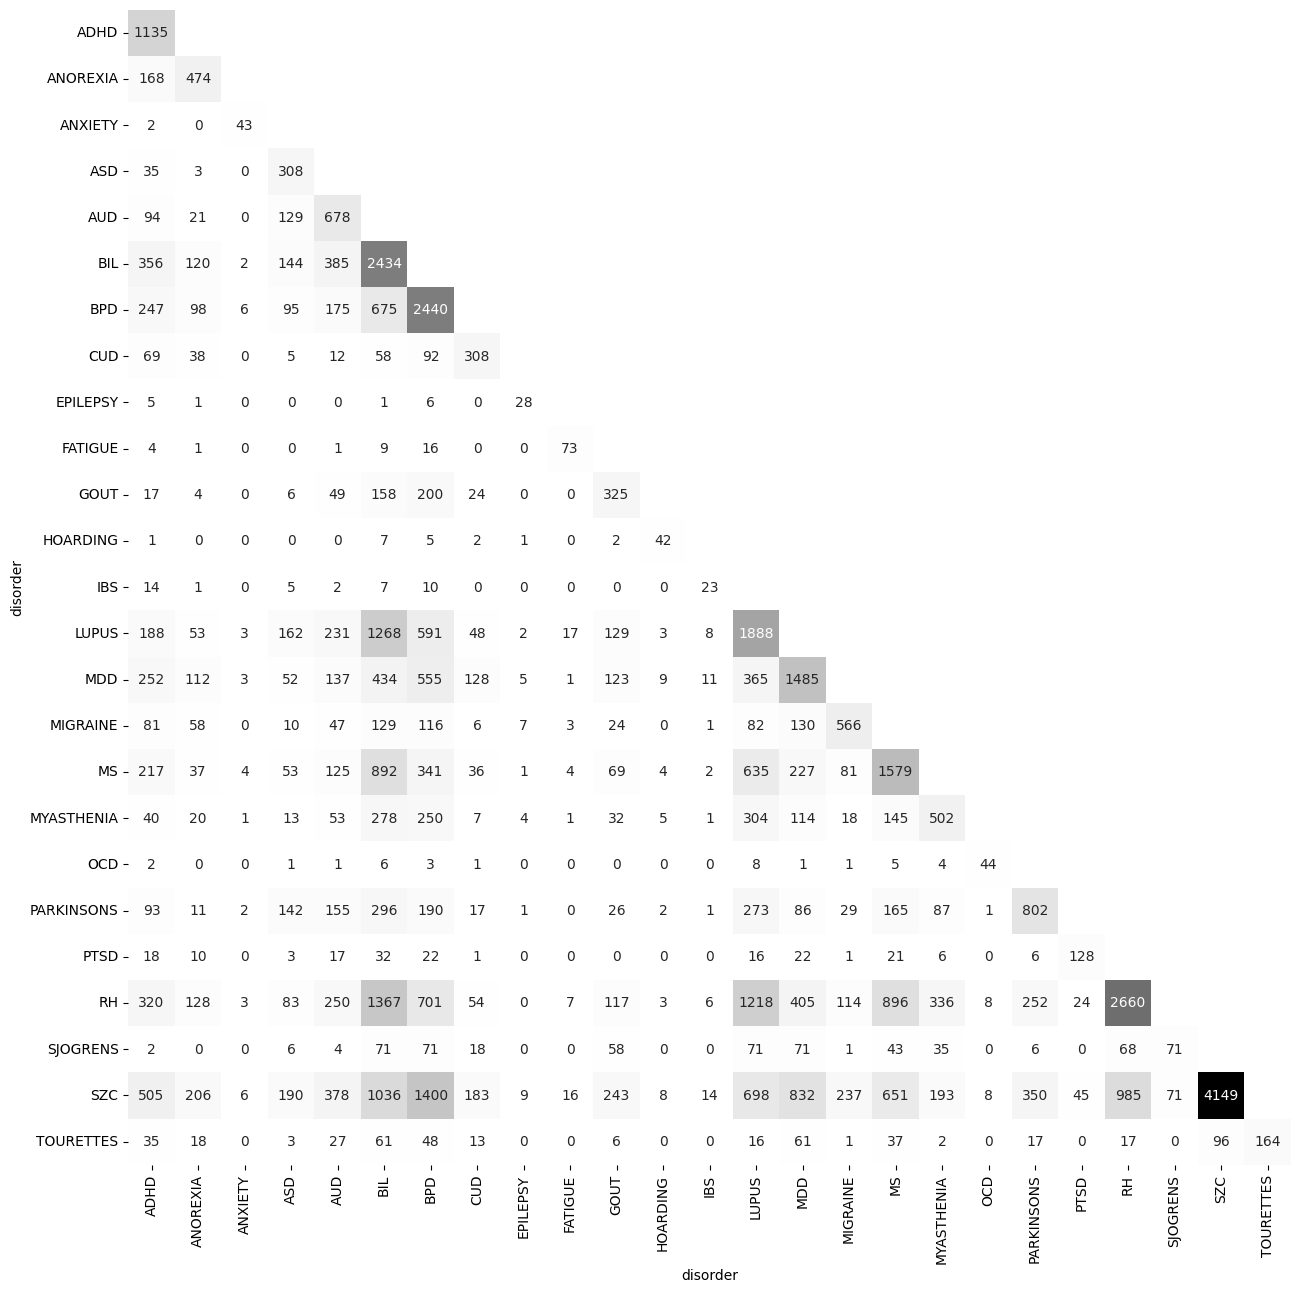

In [24]:
# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(shared_genes), k=1).astype(bool)

# Set the values in the upper triangular part to NaN
shared_genes[mask] = np.nan

# Specify the size of the heatmap
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the heatmap
sns.heatmap(shared_genes, annot=True, fmt='.0f', cmap='Greys', cbar=False)
plt.show()

In [25]:
# function to randomly select a given number of SNPs
def select_snps_randomly(df_list, number_of_snps):
        sampled_dfs = []
        for df in df_list:
            sampled = df.sample(n=number_of_snps, replace=True)
    
            sampled_df = sampled[['rsID', 'disorder']]
            sampled_df.reset_index(inplace=True, drop=True)
            # reset index
            #sampled_df.reset_index()
            sampled_dfs.append(sampled_df)
            
        return sampled_dfs

In [26]:
#function to make binary matrix with randobly selected snps
def make_random_binary_matrix(number_i, list_of_snps, number_of_snps):
    random_binary_list = []
    for i in range(number_i):
        random = select_snps_randomly(list_of_snps, number_of_snps)
        concatenated_random = pd.concat(random)
    
        binary = concatenated_random.pivot_table(index='rsID', columns='disorder', aggfunc=lambda x: 1, fill_value=0)
        random_binary_list.append(binary)
    return random_binary_list


In [27]:
finngen = pd.read_csv('FinnGen/FinnGen_table_all_diseases.csv', sep=';', index_col=0)

In [202]:
finngen.head()

,ADHD,Anorexia,Anxiety,Autism,BPD,AUD,SUD(exl. Alc.),Depression,OCD,PTSD,...,Gout,IBS,Lupus,Migraine,MS,Myasthenia Gr.,Parkinson's,Rh. Arthritis,Sjøgrens,Epilepsy
ADHD,830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Anorexia,12,1039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Anxiety,415,329.0,20992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Autism,47,0.0,134.0,293.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BPD,121,90.0,2037.0,27.0,4501.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
disorder_list = finngen.index.values.tolist()
fin_matrix = finngen.to_numpy()


In [94]:



def hypergeometric_prob(matrix, disorder_list, M):

    matrix_shape= matrix.shape
    prob_matrix = np.zeros(matrix_shape)

    for i in range(1, matrix_shape[0]):
        for j in range(i):
            x =matrix[i,j]
            n = matrix[j,j]
            N = matrix[i, i]
            #print(M,n,x)
            
            prob = hypergeom.sf(x-1, M, n, N)
            
                
            prob_matrix[i,j] = prob

    return pd.DataFrame(prob_matrix, columns=disorder_list, index=disorder_list)

   

In [95]:
disorders = shared_genes.columns.tolist()
disorder_matrix = shared_genes.to_numpy()



In [161]:
genes_prob_list = []
finngen_p = hypergeometric_prob(fin_matrix,disorder_list, 500000)
prob_genes_10K=hypergeometric_prob(disorder_matrix, disorders, 10000)
prob_genes_15K=hypergeometric_prob(disorder_matrix, disorders, 15000)
prob_genes_20K=hypergeometric_prob(disorder_matrix, disorders, 20000)
genes_prob_list.append(prob_genes_10K)
genes_prob_list.append(prob_genes_15K)
genes_prob_list.append(prob_genes_20K)

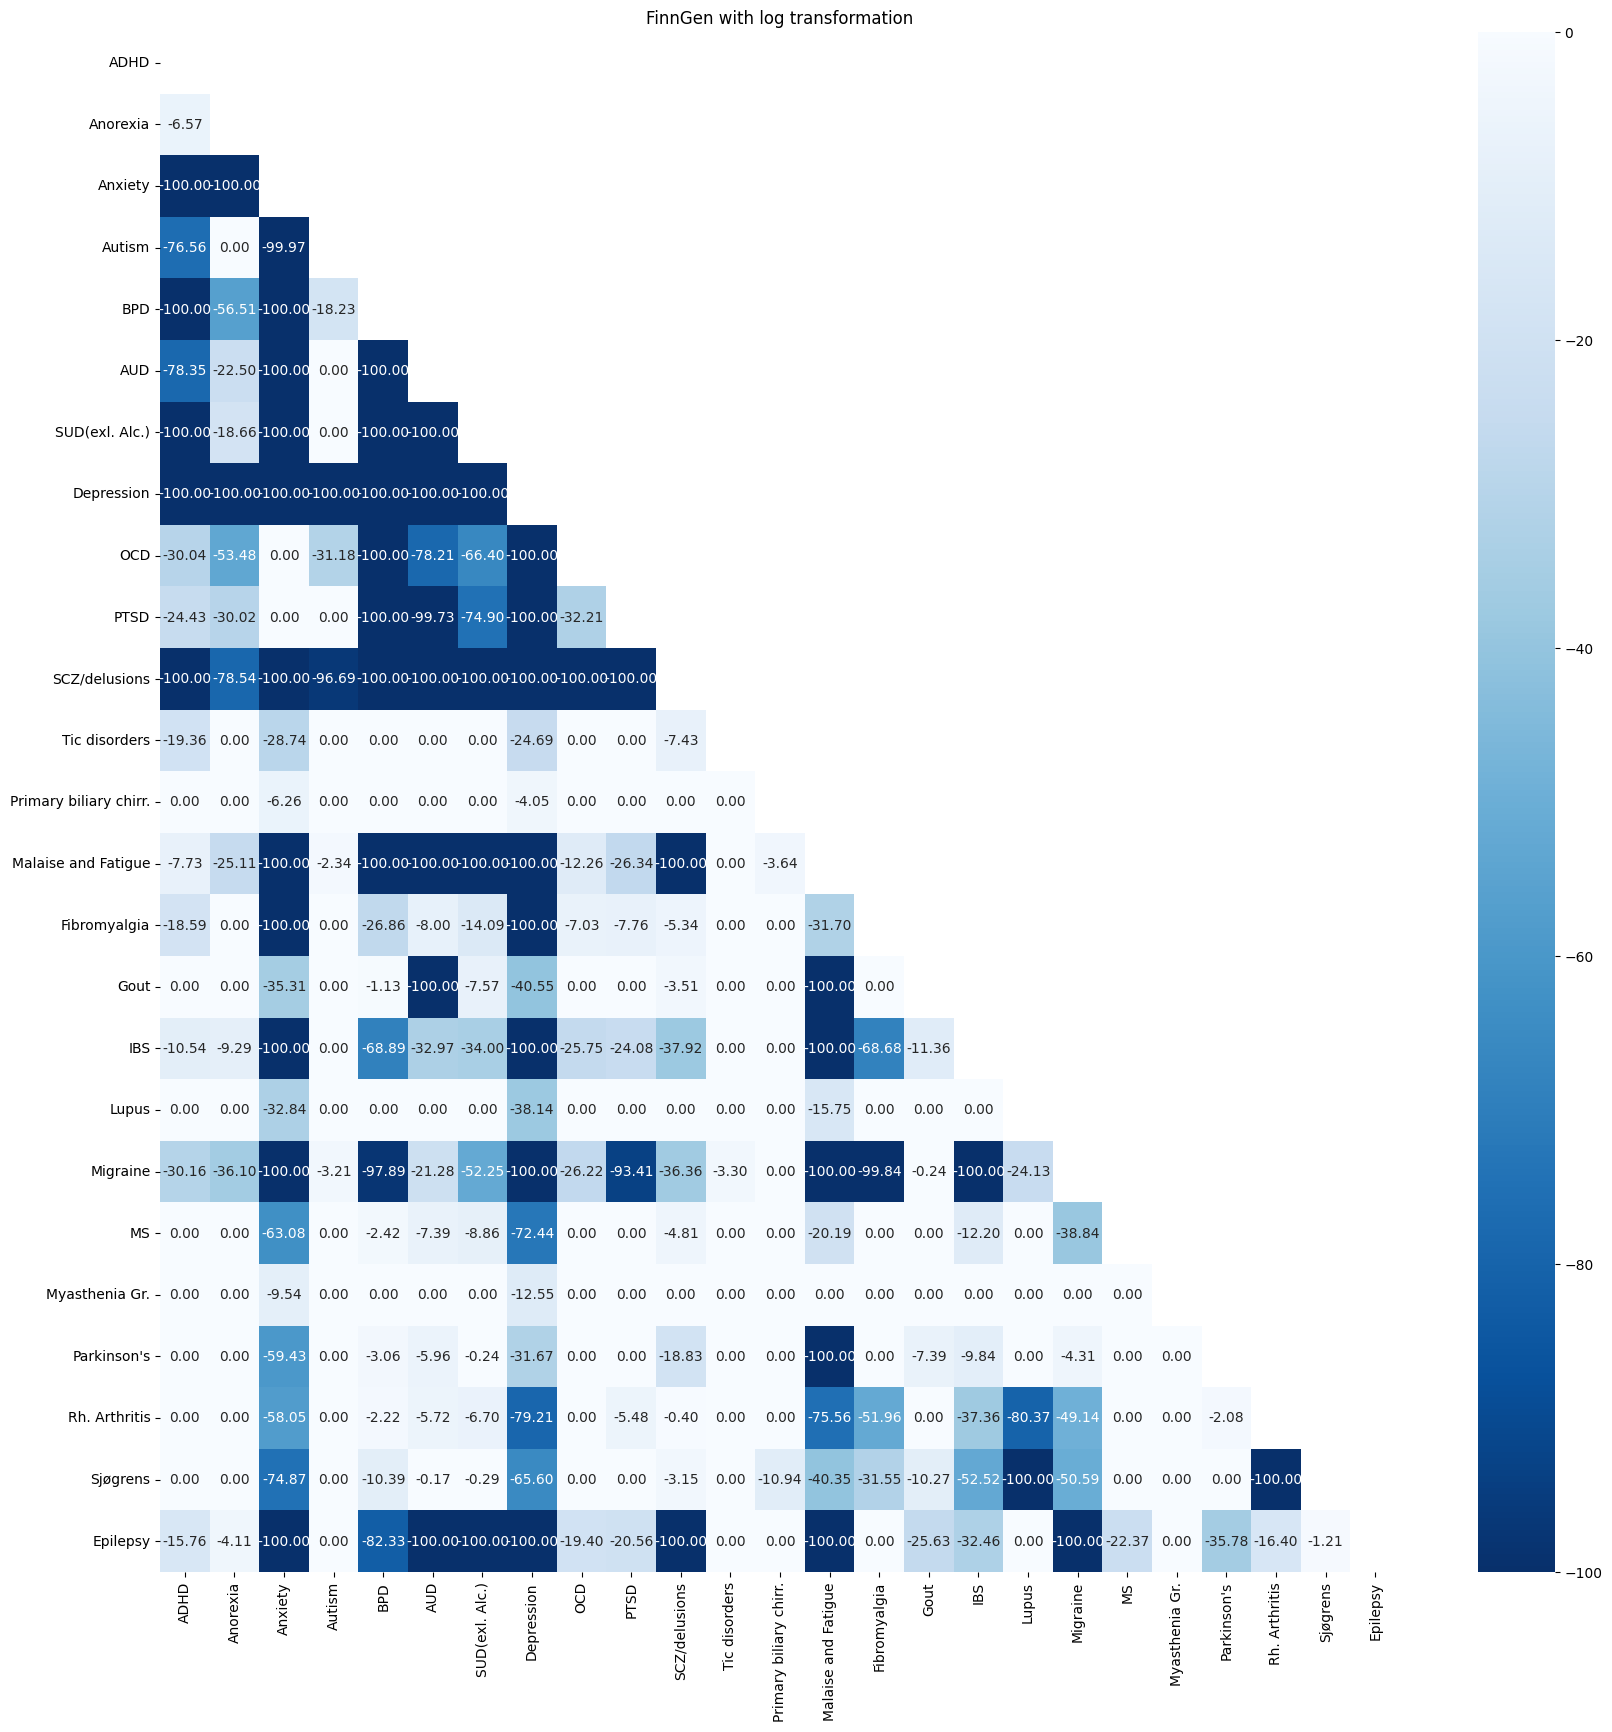

<Figure size 2000x1500 with 0 Axes>

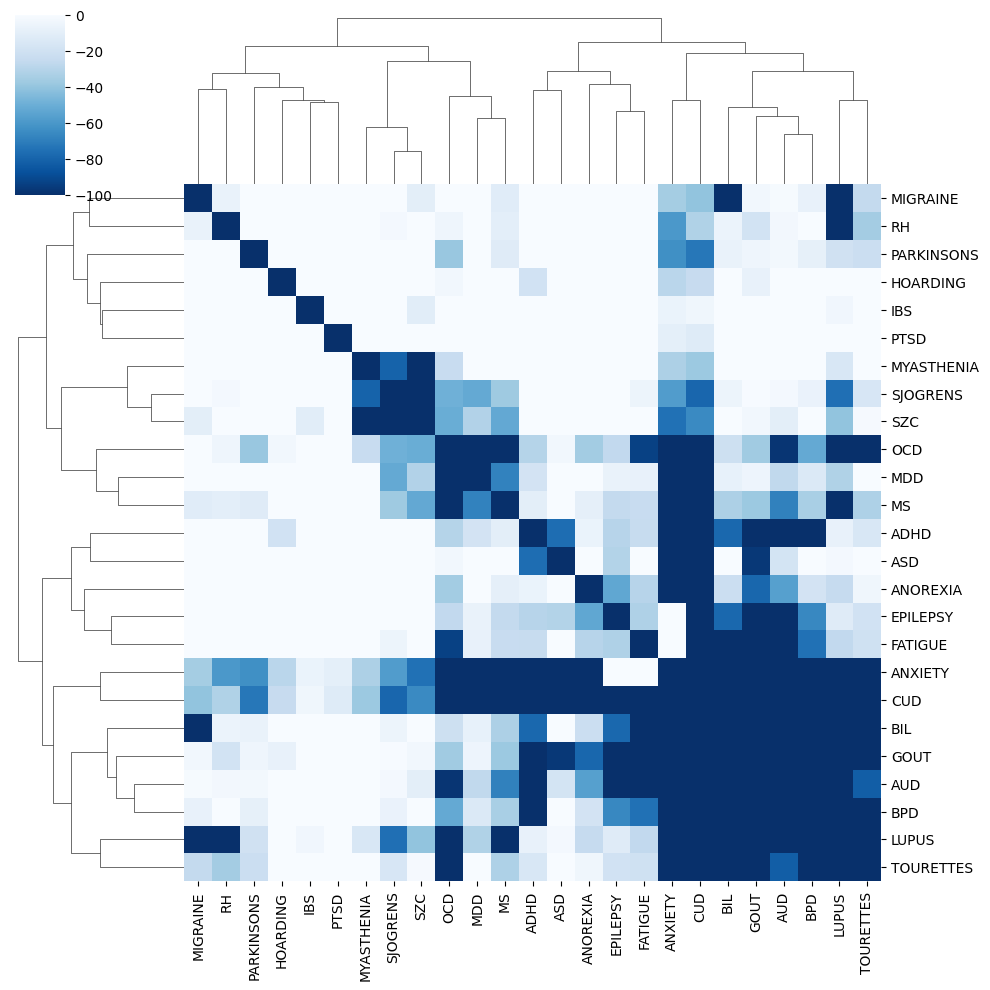

In [200]:

# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(finngen_p, dtype=bool))

# Set the upper triangular part to NaN to exclude it from the plot
finngen_p = finngen_p.mask(mask)

#Apply log transformation
finngen_log = np.log10(finngen_p+1e-100)

#reverse colormap
cmap = 'Blues'
cmap_reversed = cmap + '_r'

fig, ax = plt.subplots(figsize=(20,20))
plt.title('FinnGen with log transformation')
sns.heatmap(finngen_log, annot=True,fmt='.2f',cmap=cmap_reversed, cbar=True)

full_finngen_matrix = np.tril(finngen_p) + np.tril(finngen_p, -1).T

full_finngen_df = pd.DataFrame(full_finngen_matrix, index=disorders, columns=disorders)
full_finngen_df = full_finngen_df.fillna(1e-100)
full_finngen_log = np.log10(full_finngen_df+1e-100)
plt.figure(figsize=(20,15))
sns.clustermap(full_finngen_log,cmap=cmap_reversed)
plt.show()


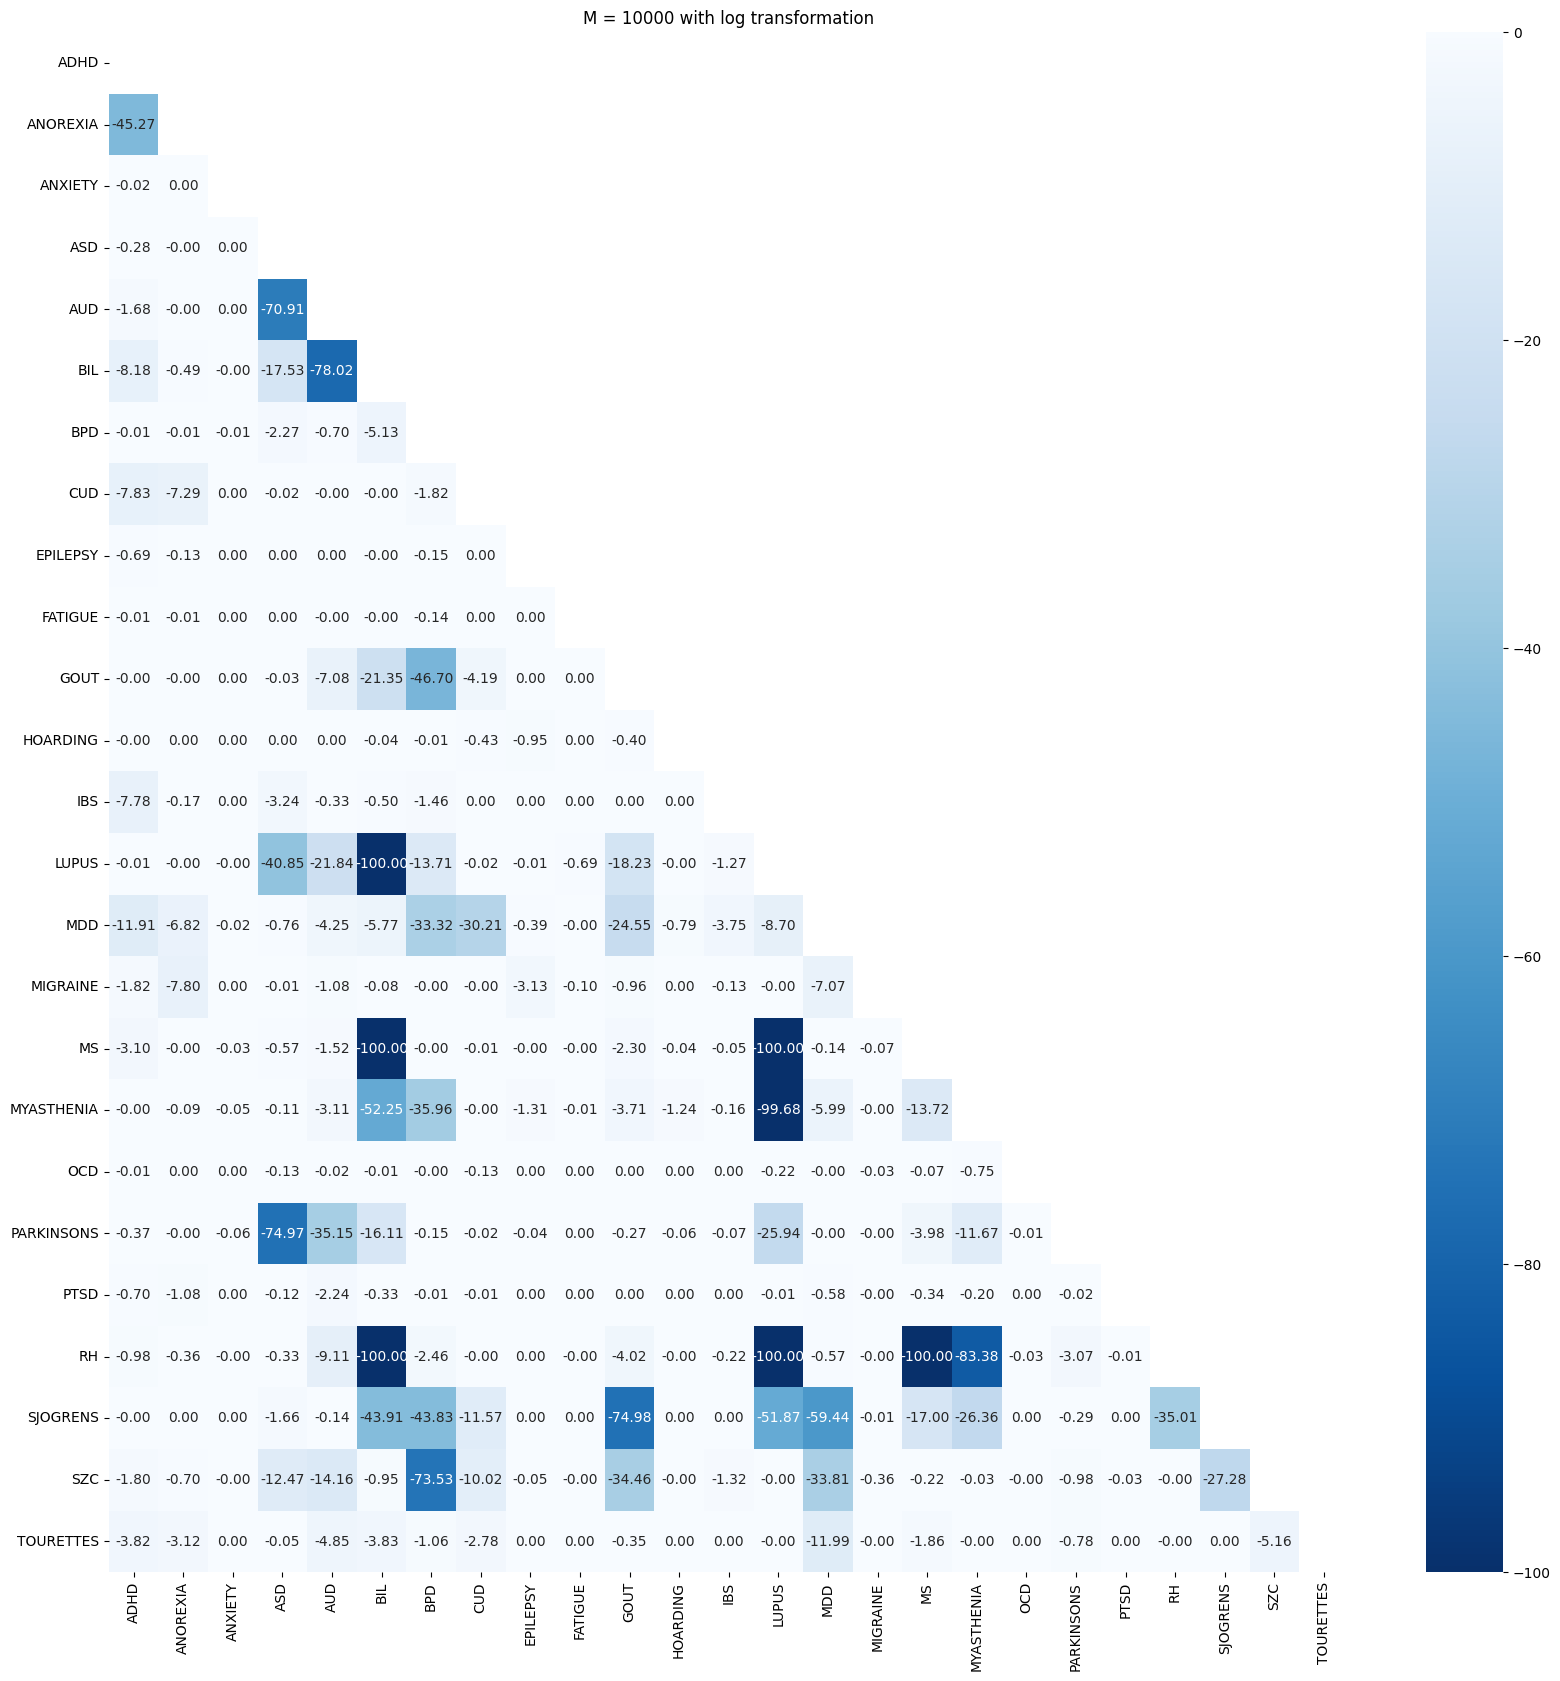

<Figure size 2000x1500 with 0 Axes>

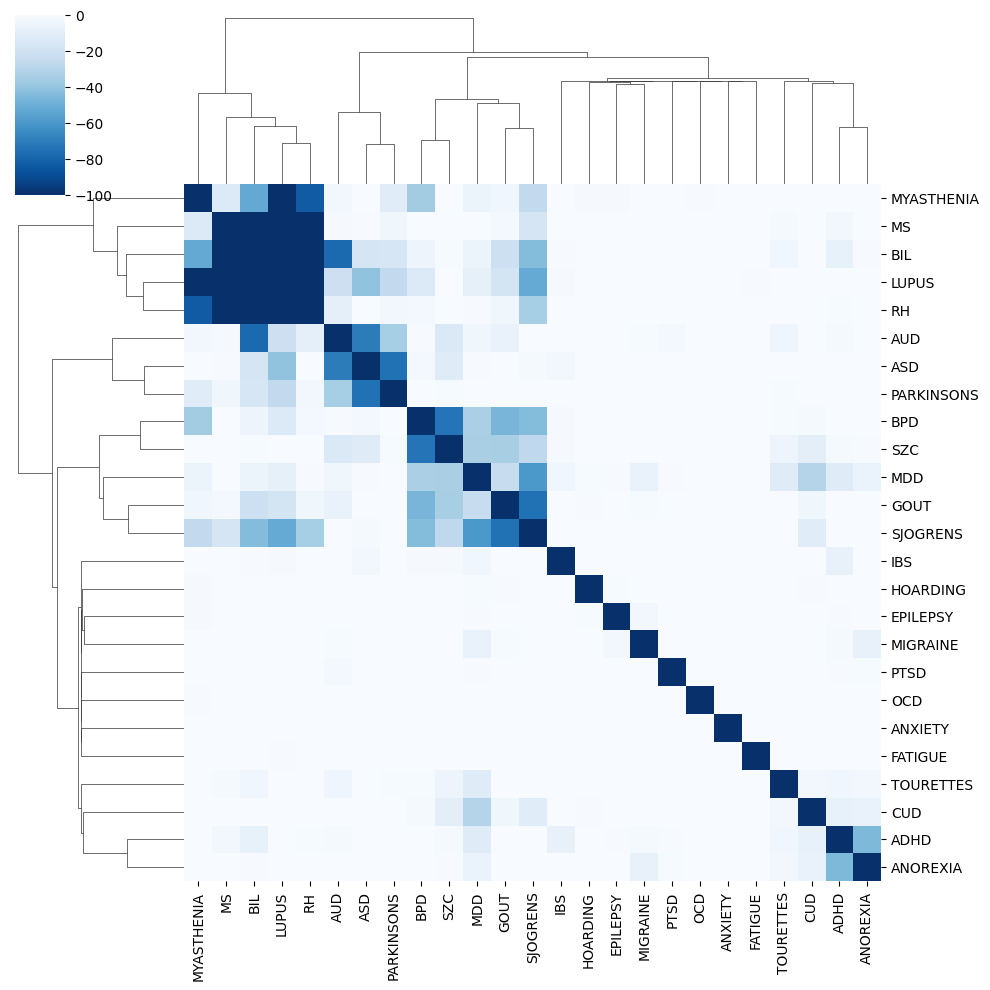

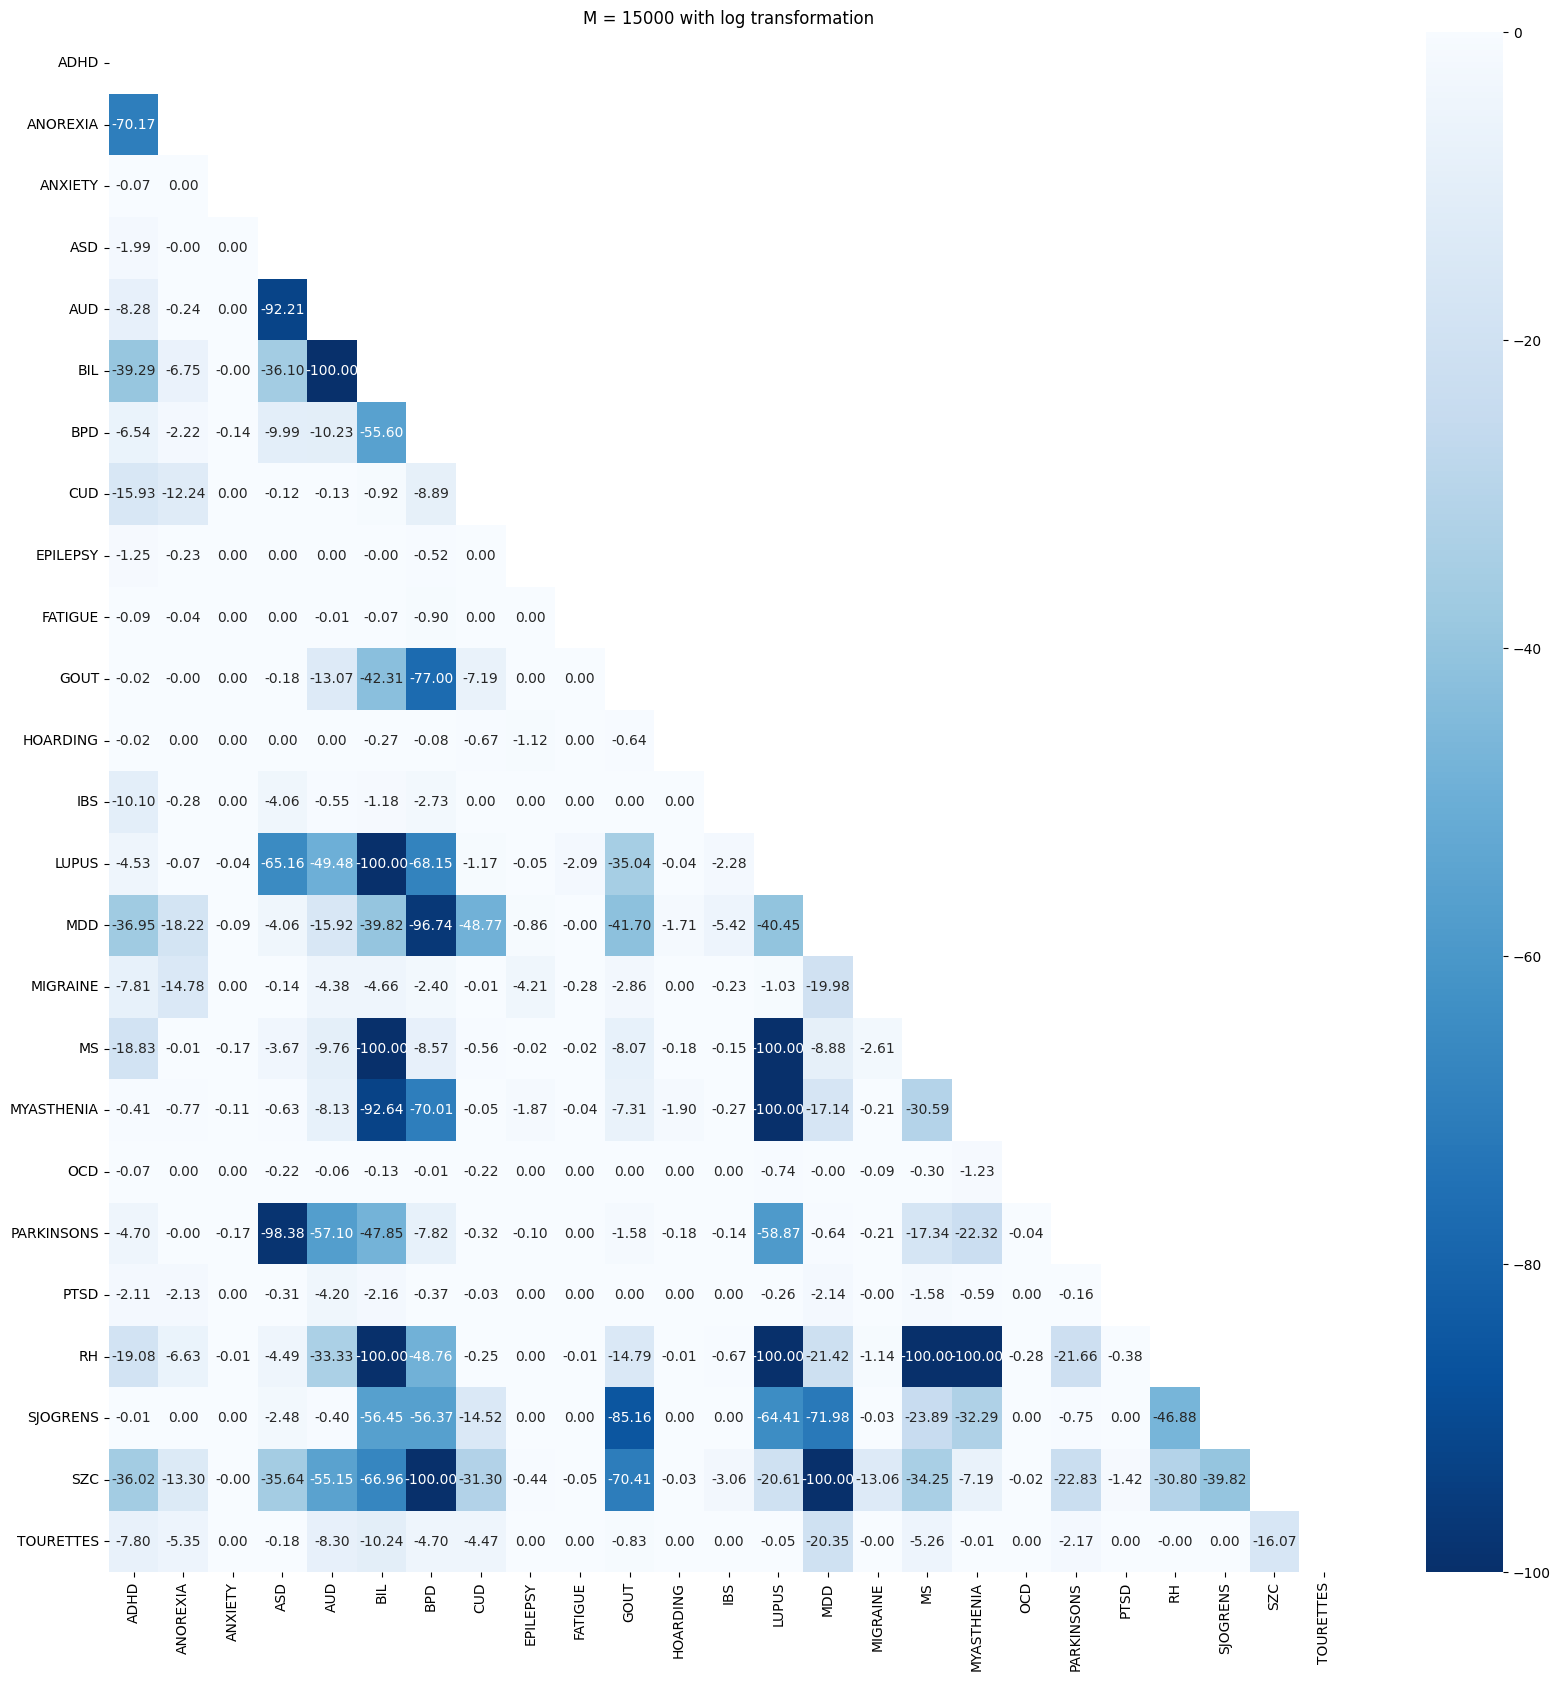

<Figure size 2000x1500 with 0 Axes>

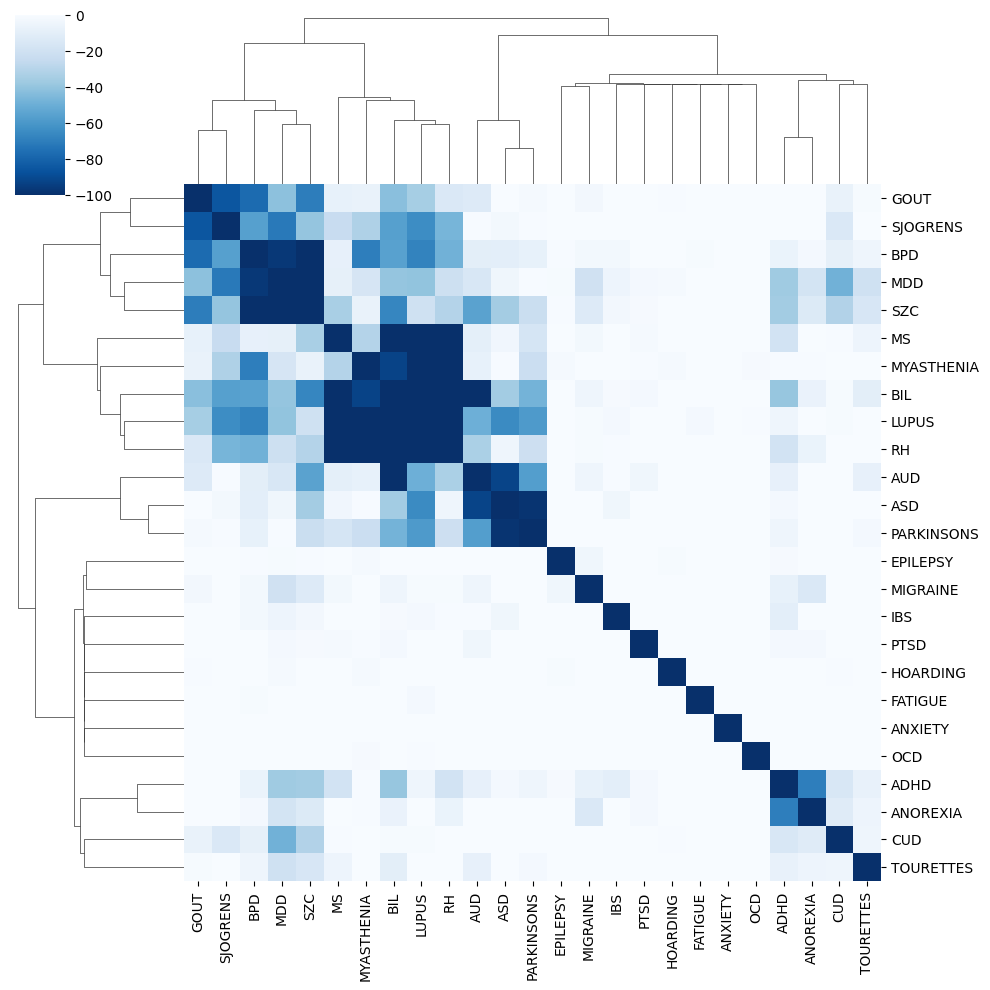

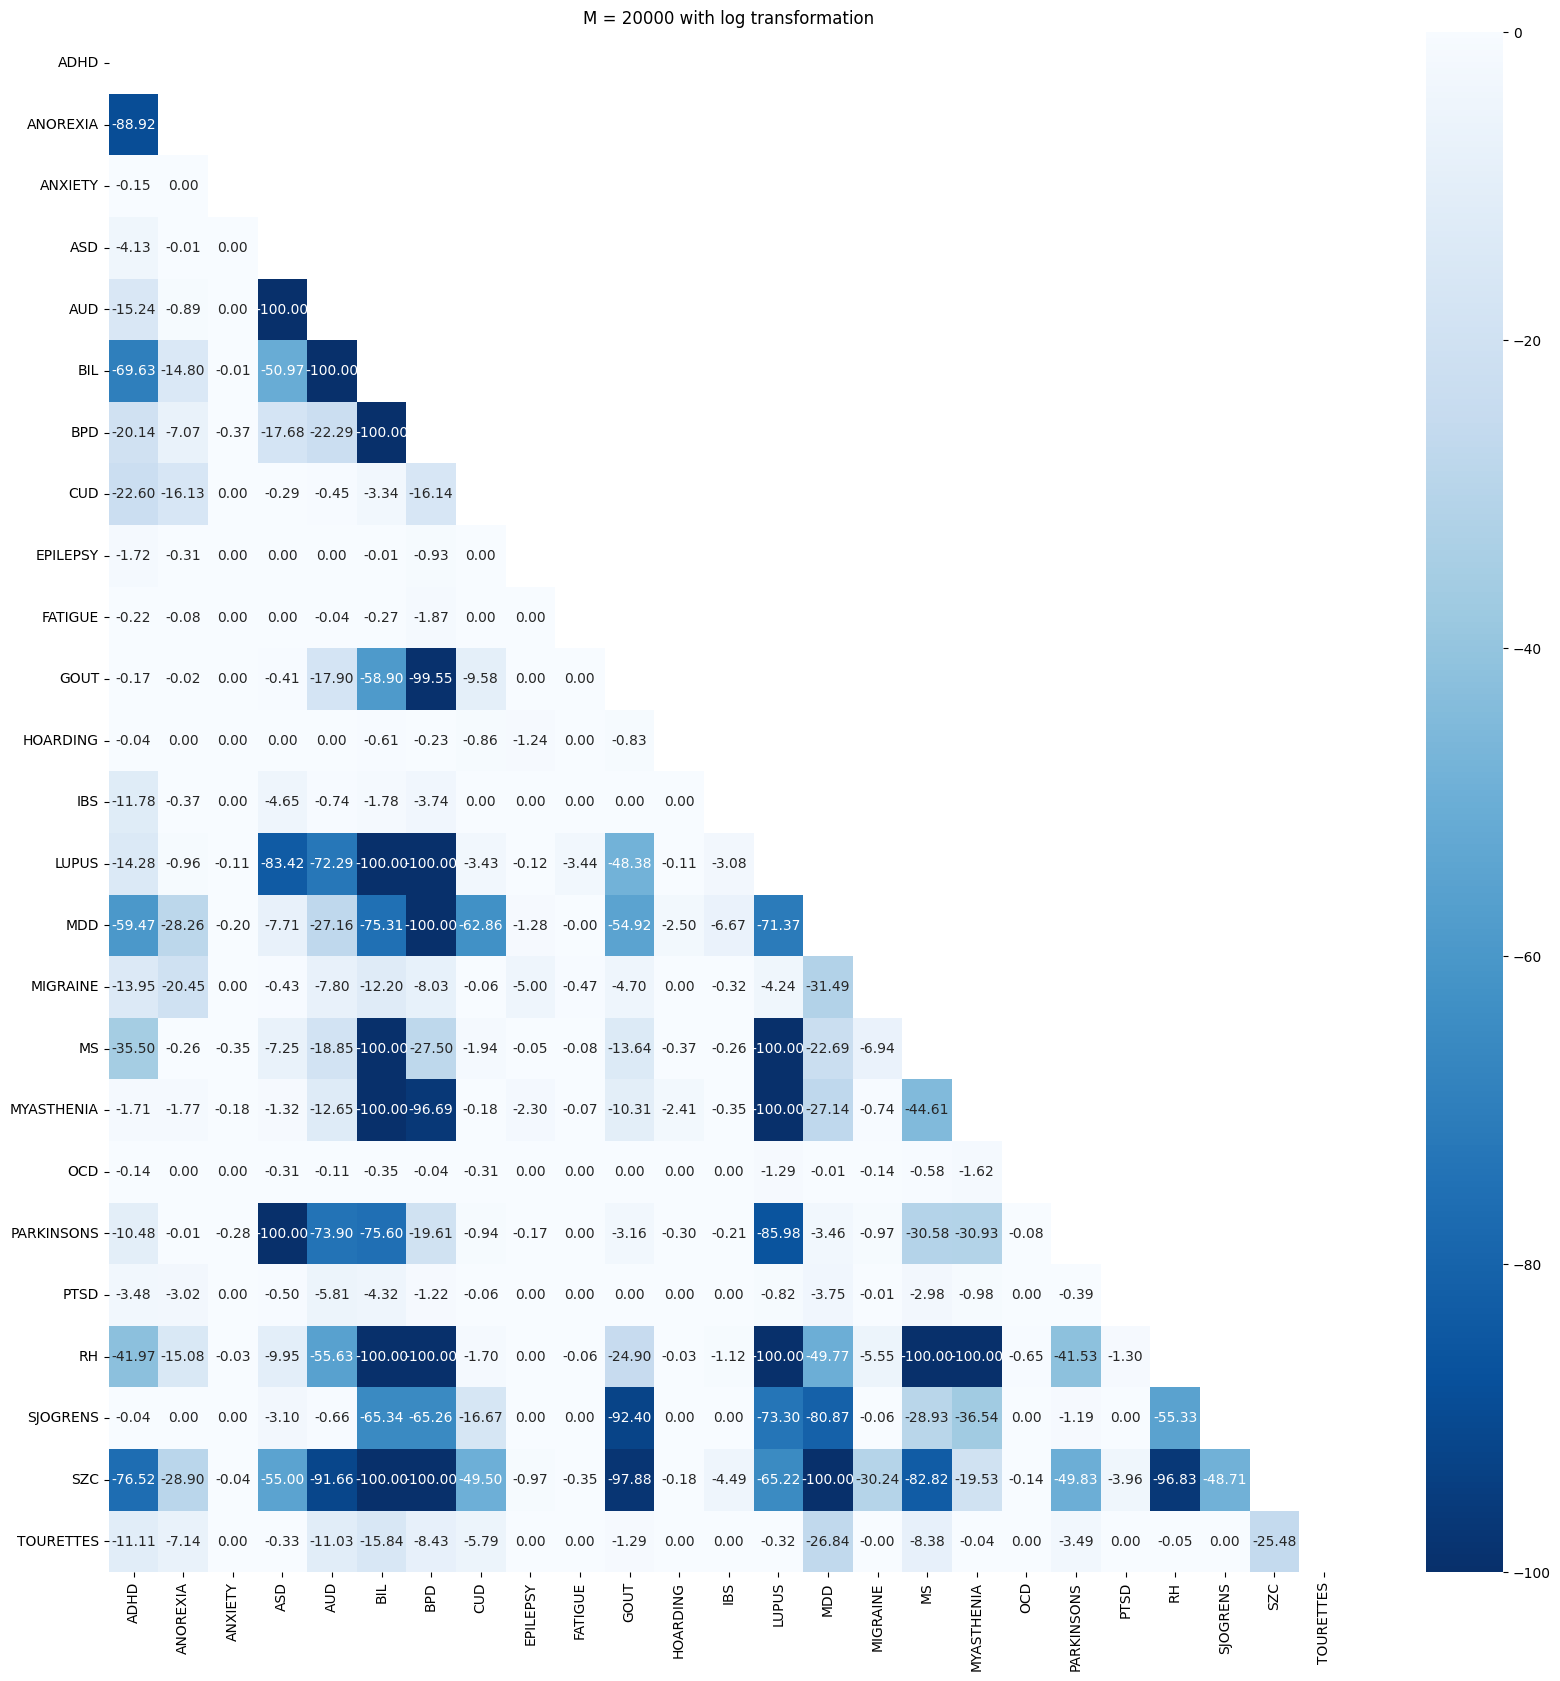

<Figure size 2000x1500 with 0 Axes>

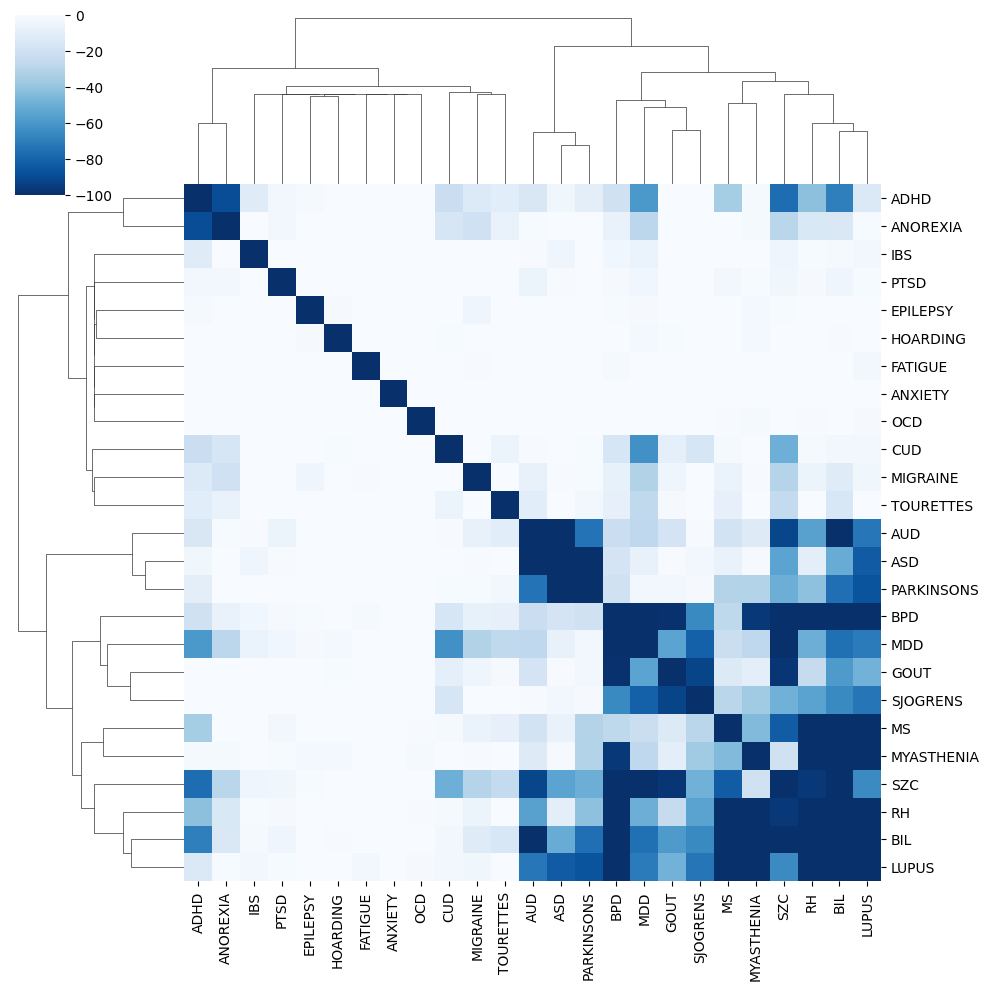

In [201]:
i = 10000
for df in genes_prob_list:
    
    # Create a mask for the upper triangular part
    mask = np.triu(np.ones_like(df, dtype=bool))

    # Set the upper triangular part to NaN to exclude it from the plot
    df = df.mask(mask)

    #Apply log transformation
    df_log = np.log10(df+1e-100)

    #reverse colormap
    cmap = 'Blues'
    cmap_reversed = cmap + '_r'
    
    fig, ax = plt.subplots(figsize=(20,20))
    plt.title(f'M = {i} with log transformation')
    sns.heatmap(df_log, annot=True,fmt='.2f',cmap=cmap_reversed, cbar=True)

    full_matrix = np.tril(df) + np.tril(df, -1).T

    full_df = pd.DataFrame(full_matrix, index=disorders, columns=disorders)
    full_df = full_df.fillna(1e-100)
    full_df_log = np.log10(full_df + 1e-100)
    plt.figure(figsize=(20,15))
    sns.clustermap(full_df_log,cmap=cmap_reversed)
    plt.show()
    i+= 5000
    